## 005 Pilot non-RL models in pymc (single subject)

Date: 22.Jul.2022

### Purpose

Implement biased and heuristic models and compare to RW

### Outline of Plan

1. Implement biased random model
2. Implement plausible heuristic model (switch after two losses)
3. Re-estimate RW models
4. WAIC model comparison

### What we did in this notebook

1. Biased model is simple to implement, essentially pass the sampled bias parameter as the p value for the Bernoulli distribution.
2. Heuristic model involves calculating the adherence to the strategy (switch after 2 losses), encoded in the 'strat' vector
3. Then loop over the strat and action vectors and return eps if strategy is followed for right machine, and 1-eps if not followed (opposite for left machine). This returns the vector of eps [representing the probabilities of choosing right machine] which is then passed into the Bernoulli distribution.
4. Ran simulations for heuristic model (looks great).
5. Ran the WAIC/LOO model comparison, heuristic model performs better than the biased model, but worse than all the RW alternatives.
6. This confirms that we can proceed with iterating the RW modeling and combining it with the craving estimations.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara

from sys import path

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## RW model classes

In [4]:
class RW:
    def __init__(self, longform, summary):
        self.name = 'RW'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))

            action_probs = self.right_action_probs(alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [5]:
class RWDecay:
    def __init__(self, longform, summary):
        self.name = 'RWDecay'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al, d):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        Qs = at.set_subtensor(Qs[1-a], Qs[1-a] + d * (0.5 - Qs[1-a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_decay, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha, sample_decay])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            untr_decay = pm.Normal('untr_decay', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            decay = pm.Deterministic('decay', pm.math.invlogit(untr_decay))

            action_probs = self.right_action_probs(alpha, beta, decay, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [6]:
class RWFictive:
    def __init__(self, longform, summary):
        self.name = 'RWFictive'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al, f_al):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        Qs = at.set_subtensor(Qs[1-a], Qs[1-a] + f_al * (r - Qs[a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_fictive_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha, sample_fictive_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            untr_fictive_alpha = pm.Normal('untr_fictive_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            fictive_alpha = pm.Deterministic('fictive_alpha', pm.math.invlogit(untr_fictive_alpha))

            action_probs = self.right_action_probs(alpha, fictive_alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [7]:
class RWSeparate:
    def __init__(self, longform, summary):
        self.name = 'RWSeparate'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, pos_al, neg_al):
        Qs = aesara.ifelse.ifelse(
            at.lt(r-Qs[a], 0),
            at.set_subtensor(Qs[a], Qs[a] + neg_al * (r - Qs[a])),
            at.set_subtensor(Qs[a], Qs[a] + pos_al * (r - Qs[a]))
        )
        
        return Qs

    def right_action_probs(self, sample_pos_alpha, sample_neg_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_pos_alpha, sample_neg_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_pos_alpha', mu=0, sigma=1)
            untr_fictive_alpha = pm.Normal('untr_neg_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            pos_alpha = pm.Deterministic('pos_alpha', pm.math.invlogit(untr_alpha))
            neg_alpha = pm.Deterministic('neg_alpha', pm.math.invlogit(untr_fictive_alpha))

            action_probs = self.right_action_probs(pos_alpha, neg_alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [64]:
rw_model = RW(longform, df_summary)
rw_model.fit(7, 'other')
rwdecay_model = RWDecay(longform, df_summary)
rwdecay_model.fit(7, 'other')
rwseparate_model = RWSeparate(longform, df_summary)
rwseparate_model.fit(7, 'other')
rwfictive_model = RWFictive(longform, df_summary)
rwfictive_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, untr_decay, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_pos_alpha, untr_neg_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, untr_fictive_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or r

## Biased model class

In [15]:
class Biased:
    def __init__(self, longform, summary):
        self.name = 'Biased'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def right_action_probs(self, sample_bias, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Return the probabilities for the right action, in the original scale
        return at.repeat(sample_bias, t_actions.shape[1])

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_bias = pm.Normal('untr_bias', mu=0, sigma=1)
            bias = pm.Deterministic('bias', pm.math.invlogit(untr_bias))

            # action_probs = self.right_action_probs(bias, act, rew)
            like = pm.Bernoulli('like', p=bias, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [16]:
biased_model = Biased(longform, df_summary)
biased_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_bias]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([<AxesSubplot:title={'center':'untr_bias'}>,
       <AxesSubplot:title={'center':'bias'}>], dtype=object)

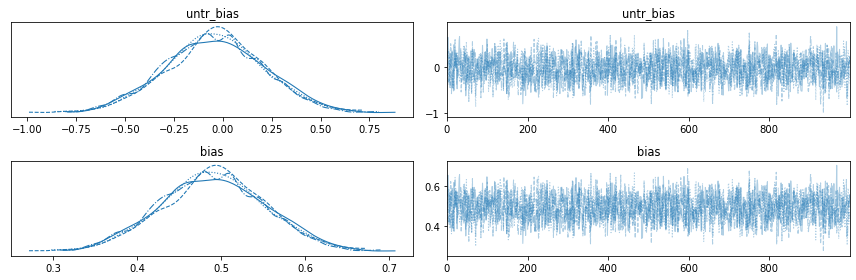

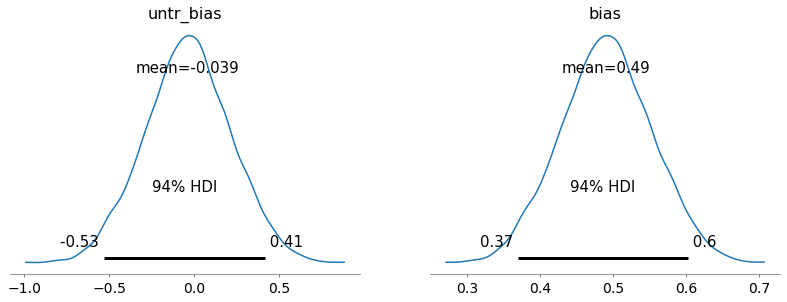

In [17]:
az.plot_trace(biased_model.trace[biased_model.pid_list[7]], var_names=['untr_bias', 'bias',])
plt.tight_layout()
az.plot_posterior(biased_model.trace[biased_model.pid_list[7]], var_names=['untr_bias', 'bias'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

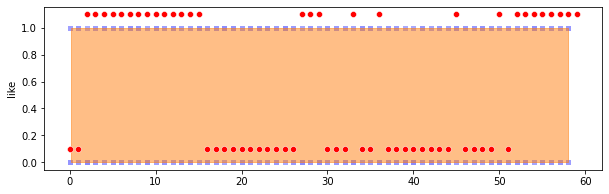

In [18]:
fig = plt.figure(figsize=(10,3))
posterior_pred = biased_model.trace[biased_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = biased_model.longform[(biased_model.longform['PID']==biased_model.pid_list[7]) & (biased_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## Heuristic model class

In [60]:
class Heuristic:
    def __init__(self, longform, summary):
        self.name = 'Heuristic'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}
    
    def add_eps(self, st, a, eps_t, eps):
        return aesara.ifelse.ifelse(
                at.eq(st, 1),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    eps,
                    1-eps
                ),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    1-eps,
                    eps
                )
            )

    def right_action_probs(self, sample_eps, actions, strat):
        t_strat = at.as_tensor_variable(strat, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_eps = at.as_tensor_variable(np.asarray(1, 'float64'))
        t_eps, updates = aesara.scan(
            fn=self.add_eps,
            sequences=[t_strat, t_actions],
            outputs_info=t_eps,
            non_sequences=[sample_eps])
        
        # # Compute the Qs values
        # t_Qs = 0.5 * at.ones((2,), dtype='float64')
        # t_Qs, updates = aesara.scan(
        #     fn=self.update_Q,
        #     sequences=[t_actions, t_rewards],
        #     outputs_info=[t_Qs],
        #     non_sequences=[sample_alpha])

        # Return the probabilities for the right action, in the original scale
        return t_eps

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        strat = np.zeros(len(act))
        for i, a in enumerate(act):
            if i < 2:
                continue
            should_switch = np.all(np.array([rew[i-2]==rew[i-1], rew[i-1]==0]), axis=0)
            do_switch = act[i-1]!=act[i]
            strat[i] = should_switch==do_switch
        strat = strat.astype(int)
        
        with pm.Model() as model:
            untr_eps = pm.Normal('untr_eps', mu=0, sigma=1)
            eps = pm.Deterministic('eps', pm.math.invlogit(untr_eps))

            action_probs = self.right_action_probs(eps, strat, act)
            like = pm.Bernoulli('like', p=action_probs[1:], observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [61]:
heu_model = Heuristic(longform, df_summary)
heu_model.fit(7, 'other')

Traceback (most recent call last):
  File "/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/multiprocessing/forkserver.py", line 280, in main
    code = _serve_one(child_r, fds,
  File "/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/multiprocessing/forkserver.py", line 319, in _serve_one
    code = spawn._main(child_r, parent_sentinel)
  File "/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_eps]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


array([<AxesSubplot:title={'center':'untr_eps'}>,
       <AxesSubplot:title={'center':'eps'}>], dtype=object)

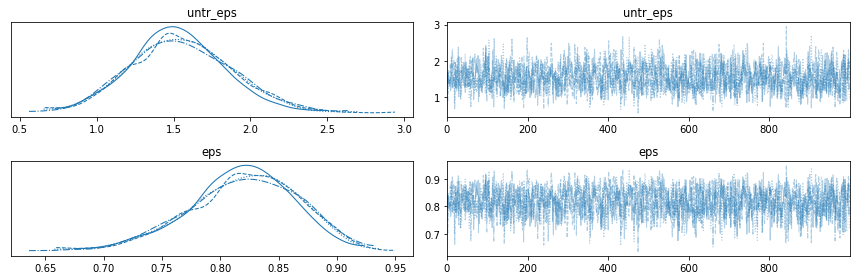

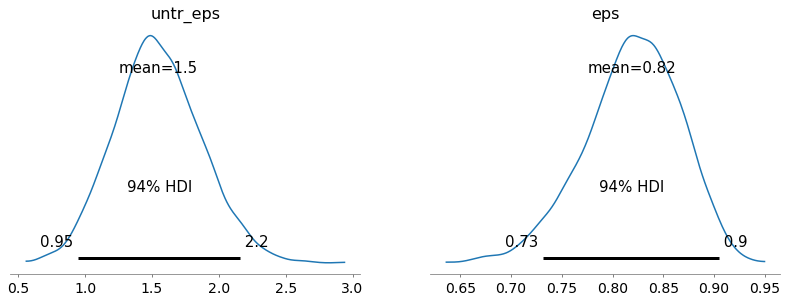

In [62]:
az.plot_trace(heu_model.trace[heu_model.pid_list[7]], var_names=['untr_eps', 'eps',])
plt.tight_layout()
az.plot_posterior(heu_model.trace[heu_model.pid_list[7]], var_names=['untr_eps', 'eps'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

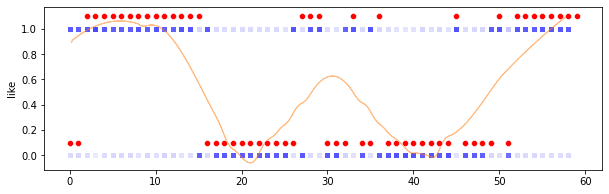

In [63]:
fig = plt.figure(figsize=(10,3))
posterior_pred = heu_model.trace[heu_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = heu_model.longform[(heu_model.longform['PID']==heu_model.pid_list[7]) & (heu_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## Model comparison between RW alternatives (LOO)

In [65]:
df_comp_loo = az.compare({
    "biased": biased_model.trace[biased_model.pid_list[7]],
    "heuristic": heu_model.trace[heu_model.pid_list[7]],
    "rw": rw_model.trace[rw_model.pid_list[7]],
    "rwdecay": rwdecay_model.trace[rwdecay_model.pid_list[7]],
    "rwfictive": rwfictive_model.trace[rwfictive_model.pid_list[7]],
    "rwseparate": rwseparate_model.trace[rwseparate_model.pid_list[7]] 
})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
rwseparate,0,-23.776057,1.512084,0.000000,6.946709e-01,4.212323,0.000000,False,log
rw,1,-24.521525,1.302149,0.745468,5.716904e-13,4.311034,0.900040,False,log
rwdecay,2,-24.635320,1.631065,0.859263,5.618190e-13,4.235269,1.378831,False,log
rwfictive,3,-25.516145,1.333283,1.740088,5.247901e-13,4.392658,1.119931,False,log
heuristic,4,-26.179651,0.813735,2.403594,3.053291e-01,4.358957,3.901040,False,log
biased,5,-41.830086,0.942730,18.054029,0.000000e+00,0.152139,4.259295,False,log


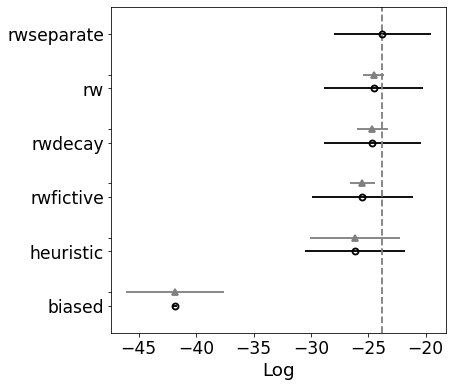

In [66]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Model comparison between RW alternatives (WAIC)

In [67]:
df_comp_waic = az.compare({
    "biased": biased_model.trace[biased_model.pid_list[7]],
    "heuristic": heu_model.trace[heu_model.pid_list[7]],
    "rw": rw_model.trace[rw_model.pid_list[7]],
    "rwdecay": rwdecay_model.trace[rwdecay_model.pid_list[7]],
    "rwfictive": rwfictive_model.trace[rwfictive_model.pid_list[7]],
    "rwseparate": rwseparate_model.trace[rwseparate_model.pid_list[7]] 
}, ic='waic')
df_comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
rwseparate,0,-23.725619,1.461646,0.000000,6.986163e-01,4.193589,0.000000,False,log
rw,1,-24.512311,1.292936,0.786692,0.000000e+00,4.308260,0.871829,False,log
rwdecay,2,-24.623143,1.618888,0.897524,0.000000e+00,4.232034,1.365131,False,log
rwfictive,3,-25.503275,1.320413,1.777656,0.000000e+00,4.388353,1.095765,False,log
heuristic,4,-26.177139,0.811223,2.451519,3.013837e-01,4.358328,3.895356,False,log
biased,5,-41.827889,0.940533,18.102269,4.807266e-13,0.152098,4.240538,False,log


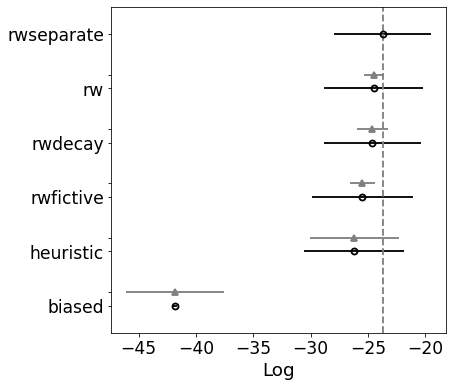

In [68]:
az.plot_compare(df_comp_waic, insample_dev=False);